# Sentiment Analysis of Amazon Food Reviews

## Project Description

This notebook demonstrates a complete machine learning pipeline for sentiment analysis using real-world Amazon food product reviews. The primary objective is to build, evaluate, and improve classification models that can accurately predict the sentiment (positive, negative, or neutral) expressed in customer reviews.

## Purpose of This Notebook

The goal of this project is twofold:
1. **To Learn and understand** data preprocessing, exploratory data analysis (EDA), natural language processing (NLP), and model building from scratch.
2. To learn how model performance can be systematically improved.

By building a sentiment classifier and then applying multiple accuracy-enhancing techniques, I aim to enhance and deepen my practical understanding of both NLP and machine learning principles.

## Dataset Information

- **Source**: Hugging Face Datasets  
- **Dataset**: [`jhan21/amazon-food-reviews-dataset`](https://huggingface.co/datasets/jhan21/amazon-food-reviews-dataset)  
- **Size**: 568,454 reviews  
- **Format**: CSV (tabular)
- **Language**: English  
- **Fields Used**: Review text, Score (1–5 stars)

This dataset contains Amazon user reviews for various food products, including helpfulness ratings, star scores, and user information. I use the star score to define sentiment polarity (e.g., 1–2 stars = negative, 3 = neutral, 4–5 = positive).

## This Notebook Covers

- Loading and cleaning the dataset  
- Sentiment labeling using review scores  
- Exploratory Data Analysis (EDA) and visualizations  
- Text preprocessing (tokenization, stopword removal, etc.)  
- Model building:
- Baseline (TF-IDF + Logistic Regression)
-  Performance evaluation using accuracy, precision, recall, F1-score  
-  Exporting trained model for deployment  

---




In [4]:
!pip install datasets


from datasets import load_dataset

# Load the Amazon Food Reviews dataset from Hugging Face
dataset = load_dataset("jhan21/amazon-food-reviews-dataset")

#Convert to pandas DataFrame
df = dataset["train"].to_pandas()

# View column names and the first few rows
print("Column Names:")
print(df.columns.tolist())

# Preview the data
df.head()


Column Names:
['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## I will now drop the columns by just keeping two required columns- Text & score. 

In [5]:
# Keeping only required columns
df = df[['Score', 'Text']]

# Checking for null values
print(df.isnull().sum())




Score    0
Text     0
dtype: int64


This dataset does not have null values in the column of text and score. 

Now i will Transform Numerical Ratings into Categorical Targets
ML classification models (like Logistic Regression, Random Forest, etc.) need discrete categories (e.g., 'positive', 'negative', 'neutral') to learn patterns. Star ratings are numerical but we care about the emotion/sentiment behind them. 

In [ ]:
# Function to convert score to sentiment
def convert_score_to_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

# Apply the function
df['sentiment'] = df['Score'].apply(convert_score_to_sentiment)

# Drop the original score column 
df = df.drop('Score', axis=1)

# Preview
df.head()


,Text,sentiment
0,I have bought several of the Vitality canned d...,positive
1,Product arrived labeled as Jumbo Salted Peanut...,negative
2,This is a confection that has been around a fe...,positive
3,If you are looking for the secret ingredient i...,negative
4,Great taffy at a great price. There was a wid...,positive


I wil import necessary libraries and NLTK Natural lkanguage tool kit. 
I used NLTK (Natural Language Toolkit) because it helps me clean and prepare text data before feeding it to my machine learning model. Since I'm working on an NLP project (classifying guest messages), the raw text has a lot of unnecessary things like:

Stopwords → words like “is,” “the,” “and,” “in,” “on” which don’t add real meaning

Punctuation → commas, periods, question marks, etc.

Lowercasing → for consistency, since “Hotel” and “hotel” should be treated the same

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import string

# Download stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\knowl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\Users\knowl\AppData\Local\Temp\ipykernel_13940\4052106841.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='Set2')


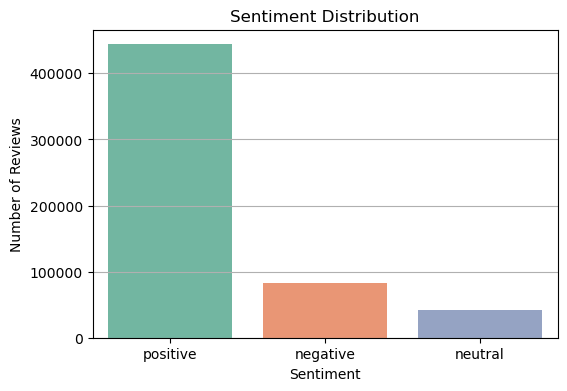

In [8]:
# Plot sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.grid(axis='y')
plt.show()


This is a huge class imbalance, the number of positive reviews are more than 400000 but the number of negative reviews and netural reviews is much less. 
This can create the following problems-
- Model bias: The model may always predict “positive” to get higher accuracy.
- Misleading metrics: Might see 85%+ accuracy, but it could be ignoring minority classes.
I will handle the imbalance before modelling after splitting the data into train and test split. 

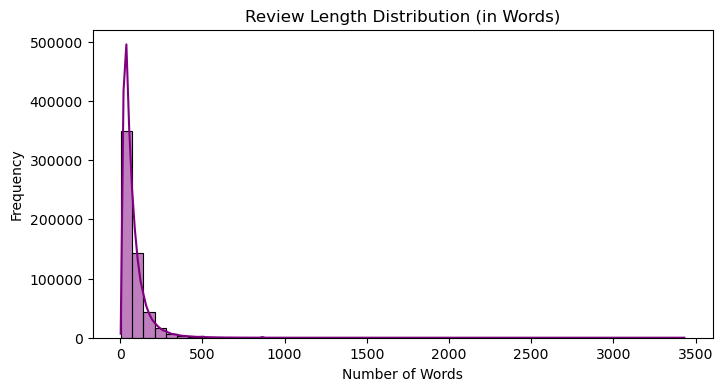

In [9]:
# Create a new column for review length
df['review_length'] = df['Text'].apply(lambda x: len(str(x).split()))

# Plot review length distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['review_length'], bins=50, kde=True, color='purple')
plt.title("Review Length Distribution (in Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


In [10]:
df['sentiment'].value_counts()


sentiment
positive    443777
negative     82037
neutral      42640
Name: count, dtype: int64

Basic text cleaning- 

In [11]:
import re
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"\d+", "", text)  # remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = " ".join([word for word in text.split() if word not in stop_words])  # remove stopwords
    return text

df['cleaned_text'] = df['Text'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\knowl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Encoding labels- positive, neutral, negative.

In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])

# Mapping will be saved like this:
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_map)  # Example: {'negative': 0, 'neutral': 1, 'positive': 2}


{'negative': 0, 'neutral': 1, 'positive': 2}


- Text Vectorization using TF-IDF   - TF-IDF turns words into weighted numerical features.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # limit to top 5000 words
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['label']


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [15]:
from sklearn.linear_model import LogisticRegression

# Define the model with class imbalance handling
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)

# Fit the model on training data
log_reg.fit(X_train, y_train)



LogisticRegression(class_weight='balanced', max_iter=1000)

In [16]:
y_pred = log_reg.predict(X_test)
print(y_pred[:10])  # Print first 10 predictions



[2 1 2 2 2 0 1 2 2 1]


In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

    negative       0.63      0.74      0.68     16407
     neutral       0.26      0.63      0.37      8528
    positive       0.97      0.80      0.88     88756

    accuracy                           0.78    113691
   macro avg       0.62      0.72      0.64    113691
weighted avg       0.87      0.78      0.81    113691


Accuracy Score: 0.7812403796254761


Positive reviews:

Precision: 0.97 – The model is really good at correctly identifying positive reviews.

Recall: 0.80 – It successfully captured 80% of actual positive reviews.

F1-Score: 0.88 – This class performed the best overall.

Negative reviews:

Precision: 0.63 – It correctly identified 63% of predicted negatives.

Recall: 0.74 – It found 74% of all actual negative reviews.

F1-Score: 0.68 – Decent, but not as strong as positive.

Neutral reviews:

Precision: 0.26 – Very low, meaning a lot of false positives.

Recall: 0.63 – It captured over half of the true neutral reviews.

F1-Score: 0.37 – This class needs major improvement.

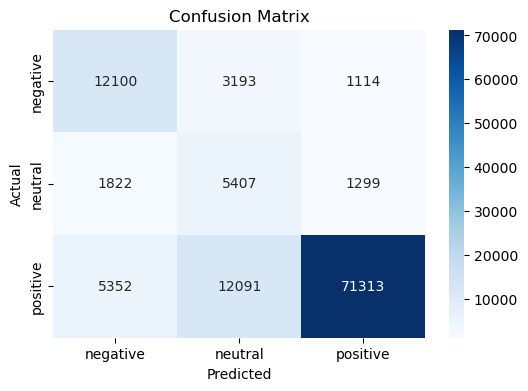

In [18]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## This Matrix Shows:
- **Rows** = Actual Labels  
- **Columns** = Predicted Labels  
Each cell tells me how many samples from a true class were predicted as a certain class.

---

## Positive Class (Bottom Row)
- Correctly predicted as **positive**: **71,313**
- Incorrectly predicted as **neutral**: **12,091**
- Incorrectly predicted as **negative**: **5,352**

The model performs really well on the positive class, which also has the most data. But still, some positive reviews are confused with neutral ones.

---

## Neutral Class (Middle Row)
- Correctly predicted as **neutral**: **5,407**
- Misclassified as **negative**: **1,822**
- Misclassified as **positive**: **1,299**

Neutral class is where the model struggles the most. It gets mixed up with both positive and negative — probably because the language in neutral reviews overlaps with both.

---

## Negative Class (Top Row)
- Correctly predicted as **negative**: **12,100**
- Misclassified as **neutral**: **3,193**
- Misclassified as **positive**: **1,114**

Multi Class ROC Curve-

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np


In [20]:
# Converting string labels to binary format for ROC
y_bin = label_binarize(y, classes=[0, 1, 2])  # adjust if your labels are different
n_classes = y_bin.shape[1]

# Split data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_bin, test_size=0.2, random_state=42, stratify=y)


In [21]:
# Logistic Regression with One-vs-Rest wrapper
ovr_model = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000))
ovr_model.fit(X_train_bin, y_train_bin)
y_score = ovr_model.decision_function(X_test_bin)


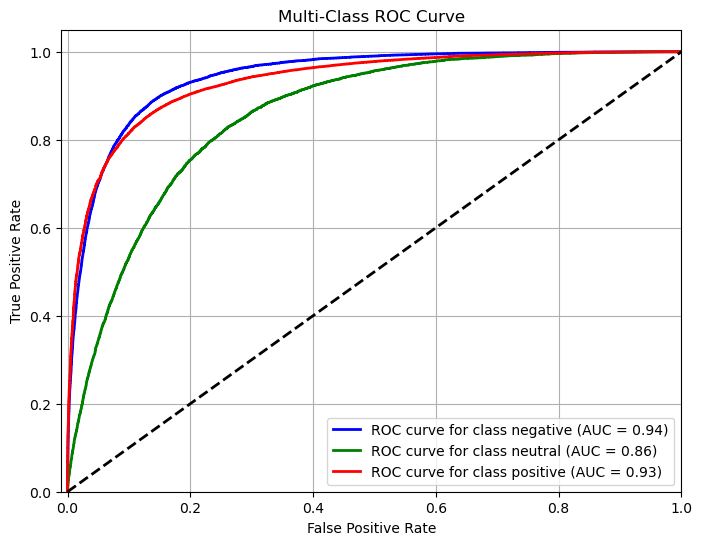

In [22]:
# Plot ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
labels = label_encoder.classes_

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


 ROC Curve Analysis
The ROC curve above represents the performance of our multi-class Logistic Regression model using a One-vs-Rest approach for sentiment classification. The three sentiment categories are positive, negative, and neutral, and each class has its own ROC curve plotted against the false positive rate and true positive rate.

- AUC Scores:
Negative (blue): AUC = 0.94 → This indicates excellent model performance in detecting negative reviews.

Positive (red): AUC = 0.93 → The model performs very well for positive sentiment, likely due to the large number of positive samples in the dataset.

Neutral (green): AUC = 0.86 → Performance is comparatively lower for neutral reviews, possibly due to class imbalance and overlap with positive/negative sentiment tones.

- Class Imbalance Impact:
The dataset is imbalanced, with positive reviews dominating the distribution. As a result:

The model performs best on positive and negative sentiments.

Neutral sentiment classification shows slightly lower performance.

- Interpretation:
All three AUC values are significantly higher than 0.5, indicating that the model performs well above random guessing for each class.

The closer the ROC curve is to the top-left corner, the better the model. In this case, all curves demonstrate strong separation capabilities.

- Now I will try to address a critical challenge often encountered in real-world sentiment datasets — class imbalance. As observed in the sentiment distribution, the dataset is heavily skewed toward positive reviews, while neutral and negative sentiments are significantly underrepresented. This imbalance can lead to biased models that perform well on the majority class but poorly on minority ones, reducing the model’s real-world effectiveness.

In [23]:
# Install imbalanced-learn 
!pip install -q imbalanced-learn


In [24]:
# Imports
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


- Applying SMOTE to training data only.

In [25]:
# Applying SMOTE to balance training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Confirming class distribution
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))


Before SMOTE: Counter({2: 355021, 0: 65630, 1: 34112})
After SMOTE: Counter({2: 355021, 0: 355021, 1: 355021})


## Applying SMOTE to Balance the Training Data – My Explanation

My dataset was heavily imbalanced — most of the training examples belonged to class `2` (positive), while classes `0` (negative) and `1` (neutral) had far fewer samples. This imbalance can make the model biased toward predicting the majority class.

So I applied **SMOTE (Synthetic Minority Oversampling Technique)** to balance the classes in the training set.

---

## What SMOTE Did:
Instead of just duplicating minority samples, SMOTE **generates synthetic examples** by interpolating between existing samples. This helps the model learn more general patterns instead of memorizing duplicates.


In [26]:
# Retraining Logistic Regression with class_weight
log_reg_balanced = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs', multi_class='multinomial')
log_reg_balanced.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_balanced = log_reg_balanced.predict(X_test)


c:\Users\knowl\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [27]:
# Classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred_balanced))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_balanced))


Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.73      0.68     16407
           1       0.27      0.62      0.37      8528
           2       0.96      0.82      0.88     88756

    accuracy                           0.79    113691
   macro avg       0.62      0.72      0.65    113691
weighted avg       0.86      0.79      0.82    113691

Confusion Matrix:
 [[12015  3146  1246]
 [ 1811  5267  1450]
 [ 5140 11154 72462]]


After applying SMOTE, the classifier showed improved balance across the classes, particularly boosting the recall of the minority classes. While overall accuracy reached 79%, the model still struggles with neutral sentiment.

- Now i will save to model to test via streamlit and evaluate if i am getting accurate results for input review. 

In [31]:
# Save the OneVsRest model
model_path = joblib.dump(ovr_model, "sentiment_model.pkl")
print("Model saved:", model_path)

# Save the vectorizer
vectorizer_path = joblib.dump(vectorizer, "vectorizer.pkl")
print("Vectorizer saved:", vectorizer_path)


Model saved: ['sentiment_model.pkl']
Vectorizer saved: ['vectorizer.pkl']
